In [12]:
#!/usr/bin/env python3

"""

.. module:: approximate likelihood analysis
   :synopsis: code to study the approximate analysis, come up with a conservative
              procedure

.. moduleauthor:: Wolfgang Waltenberger <wolfgang.waltenberger@gmail.com>

"""

# coding: utf-8

import sys,os,copy,glob,time
import numpy as np
sys.path.append(os.path.abspath('../../smodels'))
from smodels.tools.physicsUnits import fb
from smodels.tools import runtime
#from smodels.tools import statistics
from smodels.tools.simplifiedLikelihoods import UpperLimitComputer, Data, LikelihoodComputer
runtime._experimental = True
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats,integrate,optimize,special
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=2.0)
sns.set_palette(sns.color_palette("Paired"))

from tqdm.notebook import tqdm
import warnings

In [13]:
# ### Define number of observed, expected and observed events:
# ### Compute exact  likelihood

def likelihood(mu,nsig,nExp,nExpErr,nobs):
    """Marginalized likelihood for mu"""

    def integrand(nbg):
        nTot = nbg + mu*nsig
        nErr = nExpErr
        p = stats.poisson.pmf(k=nobs,mu=nTot)*stats.norm.pdf(x=nbg,loc=nExp,scale=nErr)
        return p

    #Marginalize over the background uncertainty
    result = integrate.quad(integrand, 0, max(2*(nobs-nExp),nExp+5*nExpErr))

    return result[0]

In [14]:
def p(mu,nsig,nExp,nExpErr,nobs):
    """Integral of the likelihood from zero to mu"""
    #used to normalize likelihood
    result = integrate.quad(likelihood, 0, mu,args=(nsig,nExp,nExpErr,nobs,))
    return result[0]

In [15]:
# ### Compute observed and expected upper limits
def run ( nobs, nExp, nExpErr, nsig ):
    """ run the procedure, with:
    :param nobs: number of observed
    :param nExp: number expected
    :param nExpErr: error on number expected
    """
    print ( "Starting run with nobs", nobs, "nExp", nExp )
    data = Data ( nobs, nExp, nExpErr**2, nsignal = nsig)
    computer = UpperLimitComputer ( 10000 )
    marginalize = False #True
    ULobs = computer.ulSigma ( data, marginalize=marginalize )

    ULexp = computer.ulSigma ( data, expected=True, marginalize=marginalize )

    print(r'Nobs = %1.2f, Nbg = %1.2f +- %1.2f, Nsig < %1.2f, Nsig (expected) < %1.2f'
         %(nobs,nExp,nExpErr,ULobs,ULexp))

    sigma = ULexp/1.96
    mu0 = 0

    def erfroot ( x ):
        return 0.95- (special.erf((ULobs-x)/(np.sqrt(2)*sigma)) +  special.erf(x/(np.sqrt(2)*sigma)))/(1+special.erf(x/(np.sqrt(2)*sigma)) )

    if nobs > nExp:
        ua,ub = 0,2*(3*nExpErr)
        xa,xb=1,1
        while xa*xb > .0:
            xa,xb= erfroot ( ua ), erfroot ( ub )
            ub = 2*ub
        mu0 = optimize.brentq(lambda x: erfroot(x), ua,ub )
    print ( "mu0 = ", mu0 )
    print("Erfroot[mu0]= {}".format(erfroot(mu0)))
    # mu0 = nobs - nExp
    # print ( "mu0", mu0, "nobs", nobs, "nExp", nExp )

    def llhdFromLimits(mu,mu0,sigma):
        return stats.norm.pdf(x=mu,loc=mu0,scale=sigma)

    normLim = 1 - stats.norm.cdf(0,loc=mu0,scale=sigma)
    print(normLim)
    nsteps = 100 # 100

    mulim = abs(nobs-nExp+4*nExpErr)
    norm = p((nobs-nExp)+10*nExpErr,nsig,nExp,nExpErr,nobs)
    while True:
        Lmax1 = likelihood ( mulim, nsig,nExp,nExpErr,nobs)/norm
        Lmax2 = llhdFromLimits ( mulim, mu0, sigma )/normLim
        if max(Lmax1,Lmax2)<.01:
            break
        mulim = 1.2 * mulim
    muvals = np.linspace(0, mulim, nsteps )
    
    
    smllhd = LikelihoodComputer(data)
    
    llhds_smodels_full = np.array([[mu, smllhd.marginalizedLLHD1D(mu, nll=False)] for mu in muvals])
    llhds_smodels = np.array([[mu, statistics.likelihoodFromLimits(ULobs, ULexp, mu)] for mu in muvals])
    
    llhds = np.array([[mu,likelihood(mu,nsig,nExp,nExpErr,nobs)/norm] for mu in muvals])
    llhdsApp = np.array([[mu,llhdFromLimits(mu,mu0,sigma)/normLim] for mu in muvals])
    print ( "llhds", llhds[::20] )
    print ( "llhdsApp", llhdsApp[::20] )

    mumax = llhds[np.argmax(llhds[:,1])][0]
    mumaxApp = llhdsApp[np.argmax(llhdsApp[:,1])][0]

    norm_sm_full = integrate.simpson(llhds_smodels_full[:,1], llhds_smodels_full[:,0])
    print("norm Smodels full: {}".format(norm_sm_full))
    
    norm_sm = integrate.simpson(llhds_smodels[:,1], llhds_smodels[:,0])
    print("norm Smodels: {}".format(norm_sm))
    
    
    f = plt.figure(figsize=(8,4))
    plt.plot(llhds[:,0],llhds[:,1],label='Full',linewidth=3,color="black")
    plt.plot(llhdsApp[:,0],llhdsApp[:,1],label='From Limits',linestyle='--',linewidth=3)
    plt.plot(llhds_smodels[:,0],llhds_smodels[:,1],label='Smodels',linewidth=3,color="blue")
    plt.plot(llhds_smodels_full[:,0],llhds_smodels_full[:,1],label='Smodels full',linewidth=3,color="orange")
    plt.legend()
    plt.xlabel(r'$\mu$')
    plt.ylabel(r'$L$')
    plt.text(0,llhdsApp[:,1].min(),'$\mu_{max} = %1.2f$\n$\mu_{max}^{app} = %1.2f$' %(mumax,mumaxApp),fontsize=14)
    plt.title(r'$N_{obs} = %1.2f, N_{bg} = %1.2f \pm %1.2f, \sigma_{UL}^{obs} = %1.2f, \sigma_{UL}^{exp} = %1.2f, \Delta = %1.2f$'
              %(nobs,nExp,nExpErr,ULobs,ULexp,abs(ULobs-ULexp)/(ULobs+ULexp)),fontsize=14)
    plt.savefig("llhd.png")
    #plt.show()

In [7]:
def getSRs():
    from smodels.experiment.databaseObj import Database
    db = Database ( "official" )
    ers = db.getExpResults( dataTypes=[ "efficiencyMap" ] )
    stats_ = []
    for er in ers:
        for ds in er.datasets:
            D = { "obsN": ds.dataInfo.observedN, "expectedBG": ds.dataInfo.expectedBG,
                  "bgError": ds.dataInfo.bgError, "upperLimit": ds.dataInfo.upperLimit,
                  "expectedUpperLimit": ds.dataInfo.expectedUpperLimit }
            stats_.append ( D )
    return stats_

In [8]:
from smodels.experiment.databaseObj import Database

In [9]:
stats_ = getSRs()

In [10]:
j = 101
run(int(stats_[j]["obsN"]), stats_[j]["expectedBG"], stats_[j]["bgError"], 1)

Starting run with nobs 7838 nExp 7584.0
Nobs = 7838.00, Nbg = 7584.00 +- 433.00, Nsig < 1116.72, Nsig (expected) < 865.72
mu0 =  337.67114850468397
Erfroot[mu0]= 0.0
0.777711801905218


NameError: name 'statistics' is not defined

In [11]:
def evLlhd(mulim, nobs, nExp, nExpErr, nsig):
    """Expected Value for the exact likelihood by Integration from zero to mulim"""
    norm_ = p(mulim,nsig,nExp,nExpErr,nobs)
    
    integrand = lambda mu: mu*likelihood(mu,nsig,nExp,nExpErr,nobs)/norm_
    result = integrate.quad(integrand, 0, mulim)
    return result[0]

def varLlhd(mulim, ev, nobs, nExp, nExpErr, nsig ):
    """Variance for the exact likelihood by integration from 0 to mulim"""
    norm_ = p(mulim,nsig,nExp,nExpErr,nobs)
    
    integrand = lambda mu: (mu**2)*likelihood(mu,nsig,nExp,nExpErr,nobs)/norm_
    result = integrate.quad(integrand, 0, mulim)
    E_x2 = result[0]
    E_x = ev
    return (E_x2 - E_x**2)

def modLlhd(mu0, nobs, nExp, nExpErr, nsig):
    """Find Mode of exact likelihood"""
    fun_ = lambda mu: -likelihood(mu, nsig, nExp, nExpErr, nobs)
    res = optimize.minimize(fun=fun_, x0=mu0, method="SLSQP", bounds=[(0.,np.inf)])
    return float(res["x"])

In [14]:
def evLlhdApp (mu0, sigma):
    lam = np.exp(-mu0**2/(2*sigma**2)) / (np.sqrt(2*np.pi)*(1 - stats.norm.cdf(0,loc=mu0,scale=sigma)))
    return (mu0 +(sigma*lam))

def varLlhdApp(mu0, sigma):
    lam = np.exp(-mu0**2/(2*sigma**2)) / (np.sqrt(2*np.pi)*(1 - stats.norm.cdf(0,loc=mu0,scale=sigma)))
    return(sigma**2*(1 - lam*mu0/sigma - lam**2))

# to do!!def modLlhdApp(mu0)

In [15]:
def compareLikelihoods( nobs, nExp, nExpErr, nsig, plot, print_ ):
    data = Data ( nobs, nExp, nExpErr**2, nsignal = nsig )
    computer = UpperLimitComputer ( 10000 )
    marginalize = False #True
    ULobs = computer.ulSigma ( data, marginalize=marginalize )
    ULexp = computer.ulSigma ( data, expected=True, marginalize=marginalize )

    sigma = ULexp/1.96
    def erfroot ( x ):
        return 0.95- (special.erf((ULobs-x)/(np.sqrt(2)*sigma)) +  special.erf(x/(np.sqrt(2)*sigma)))/(1+special.erf(x/(np.sqrt(2)*sigma)) )
    
    mu0 = 0
    if nobs > nExp:
        ua,ub = 0,2*(3*nExpErr)
        xa,xb=1,1
        while xa*xb > .0:
            xa,xb= erfroot ( ua ), erfroot ( ub )
            ub = 2*ub
        mu0 = optimize.brentq(lambda x: erfroot(x), ua,ub )
    
    def llhdFromLimits(mu,mu0,sigma):
        return stats.norm.pdf(x=mu,loc=mu0,scale=sigma)

    normLim = 1 - stats.norm.cdf(0,loc=mu0,scale=sigma)

    nsteps = 100 # 100
    
    mulim = abs(nobs-nExp+4*nExpErr)
    norm = p((nobs-nExp)+10*nExpErr,nsig,nExp,nExpErr,nobs)
    while True:
        Lmax1 = likelihood ( mulim, nsig,nExp,nExpErr,nobs)/norm
        Lmax2 = llhdFromLimits ( mulim, mu0, sigma )/normLim
        if max(Lmax1,Lmax2)<.01:
            break
        mulim = 1.2 * mulim
    norm = p(mulim,nsig,nExp,nExpErr,nobs)
    
    
    ev_ex = evLlhd(mulim, nobs, nExp, nExpErr, nsig )
    var_ex =  varLlhd(mulim, ev_ex, nobs, nExp, nExpErr, nsig )
    mod_ex = modLlhd(mu0, nobs, nExp, nExpErr, nsig)
    
    ev_app = evLlhdApp(mu0, sigma)
    var_app = varLlhdApp(mu0, sigma)
    mod_app = mu0
    
    if print_:   
        print("\tE[mu] \t\tVar[mu] \tMode[mu]\
            \nFull \t{:7.4f} \t{:7.4f} \t{:7.4f}\
            \nApp \t{:7.4f} \t{:7.4f} \t{:7.4f}".format(ev_ex, var_ex, mod_ex, ev_app, var_app, mod_app))

    if plot:
        muvals = np.linspace(0, mulim, nsteps )
        llhds = np.array([[mu,likelihood(mu,nsig,nExp,nExpErr,nobs)/norm] for mu in muvals])
        llhdsApp = np.array([[mu,llhdFromLimits(mu,mu0,sigma)/normLim] for mu in muvals])
      
        mumax = llhds[np.argmax(llhds[:,1])][0]
        mumaxApp = llhdsApp[np.argmax(llhdsApp[:,1])][0]

        f = plt.figure(figsize=(8,4))
        plt.plot(llhds[:,0],llhds[:,1],label='Full',linewidth=3,color="black")
        plt.plot(llhdsApp[:,0],llhdsApp[:,1],label='From Limits',linestyle='--',linewidth=3)
        plt.legend()
        plt.xlabel(r'$\mu$')
        plt.ylabel(r'$L$')
        plt.text(0,llhdsApp[:,1].min(),'$\mu_{max} = %1.2f$\n$\mu_{max}^{app} = %1.2f$' %(mumax,mumaxApp),fontsize=14)
        plt.title(r'$N_{obs} = %1.2f, N_{bg} = %1.2f \pm %1.2f, \sigma_{UL}^{obs} = %1.2f, \sigma_{UL}^{exp} = %1.2f, \Delta = %1.2f$'
                  %(nobs,nExp,nExpErr,ULobs,ULexp,abs(ULobs-ULexp)/(ULobs+ULexp)),fontsize=14)
        plt.savefig("llhd.png")
        #plt.show()
        
    return({"ev_ex":ev_ex, "var_ex":var_ex, "mod_ex":mod_ex, "ev_app":ev_app, "var_app":var_app, "mod_app":mod_app})
 

In [30]:
def compareLikelihoods3( nobs, nExp, nExpErr, nsig, plot, print_ ):
    data = Data ( nobs, nExp, nExpErr**2, nsignal = nsig )
    computer = UpperLimitComputer ( 10000 )
    marginalize = False #True
    ULobs = computer.ulSigma ( data, marginalize=marginalize )
    ULexp = computer.ulSigma ( data, expected=True, marginalize=marginalize )

    sigma = ULexp/1.96
    def erfroot ( x ):
        return 0.95- (special.erf((ULobs-x)/(np.sqrt(2)*sigma)) +  special.erf(x/(np.sqrt(2)*sigma)))/(1+special.erf(x/(np.sqrt(2)*sigma)) )
    
    mu0 = 0
    if nobs > nExp:
        ua,ub = 0,2*(3*nExpErr)
        xa,xb=1,1
        while xa*xb > .0:
            xa,xb= erfroot ( ua ), erfroot ( ub )
            ub = 2*ub
        mu0 = optimize.brentq(lambda x: erfroot(x), ua,ub )
    
    def llhdFromLimits(mu,mu0,sigma):
        return stats.norm.pdf(x=mu,loc=mu0,scale=sigma)

    normLim = 1 - stats.norm.cdf(0,loc=mu0,scale=sigma)

    nsteps = 100 # 100
    
    mulim = abs(nobs-nExp+4*nExpErr)
    norm = p((nobs-nExp)+10*nExpErr,nsig,nExp,nExpErr,nobs)
    while True:
        Lmax1 = likelihood ( mulim, nsig,nExp,nExpErr,nobs)/norm
        Lmax2 = llhdFromLimits ( mulim, mu0, sigma )/normLim
        if max(Lmax1,Lmax2)<.01:
            break
        mulim = 1.2 * mulim
    norm = p(mulim,nsig,nExp,nExpErr,nobs)
    
    
    ev_ex = evLlhd(mulim, nobs, nExp, nExpErr, nsig )
    var_ex =  varLlhd(mulim, ev_ex, nobs, nExp, nExpErr, nsig )
    mod_ex = modLlhd(mu0, nobs, nExp, nExpErr, nsig)
    
    ev_app = evLlhdApp(mu0, sigma)
    var_app = varLlhdApp(mu0, sigma)
    mod_app = mu0
    
    if print_:   
        print("\tE[mu] \t\tVar[mu] \tMode[mu]\
            \nFull \t{:7.4f} \t{:7.4f} \t{:7.4f}\
            \nApp \t{:7.4f} \t{:7.4f} \t{:7.4f}".format(ev_ex, var_ex, mod_ex, ev_app, var_app, mod_app))

    if plot:
        muvals = np.linspace(0, mulim, nsteps )
        llhds = np.array([[mu,likelihood(mu,nsig,nExp,nExpErr,nobs)/norm] for mu in muvals])
        llhdsApp = np.array([[mu,llhdFromLimits(mu,mu0,sigma)/normLim] for mu in muvals])
      
        mumax = llhds[np.argmax(llhds[:,1])][0]
        mumaxApp = llhdsApp[np.argmax(llhdsApp[:,1])][0]

        f = plt.figure(figsize=(8,4))
        plt.plot(llhds[:,0],llhds[:,1],label='Full',linewidth=3,color="black")
        plt.plot(llhdsApp[:,0],llhdsApp[:,1],label='From Limits',linestyle='--',linewidth=3)
        plt.legend()
        plt.xlabel(r'$\mu$')
        plt.ylabel(r'$L$')
        plt.text(0,llhdsApp[:,1].min(),'$\mu_{max} = %1.2f$\n$\mu_{max}^{app} = %1.2f$' %(mumax,mumaxApp),fontsize=14)
        plt.title(r'$N_{obs} = %1.2f, N_{bg} = %1.2f \pm %1.2f, \sigma_{UL}^{obs} = %1.2f, \sigma_{UL}^{exp} = %1.2f, \Delta = %1.2f$'
                  %(nobs,nExp,nExpErr,ULobs,ULexp,abs(ULobs-ULexp)/(ULobs+ULexp)),fontsize=14)
        plt.savefig("llhd.png")
        #plt.show()
        
    return({"ev_ex":ev_ex, "var_ex":var_ex, "mod_ex":mod_ex, "ev_app":ev_app, "var_app":var_app, "mod_app":mod_app})
 

	E[mu] 		Var[mu] 	Mode[mu]            
Full 	 0.9927 	 0.9499 	 0.0000            
App 	 1.8474 	 1.9480 	 0.0000


{'ev_ex': 0.9926906703219824,
 'var_ex': 0.9499297078325484,
 'mod_ex': 0.0,
 'ev_app': 1.847387282128505,
 'var_app': 1.9480364047526573,
 'mod_app': 0}

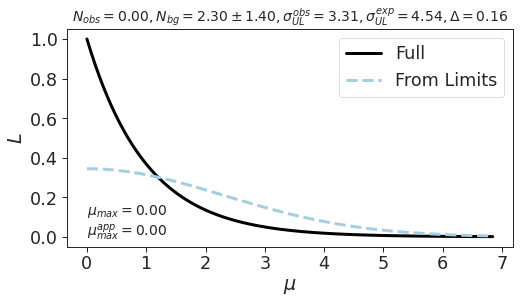

In [33]:
#look at single event-data
j = 110
plot = True
print_ = True
compareLikelihoods(stats_[j]["obsN"], stats_[j]["expectedBG"], stats_[j]["bgError"], 1, plot, print_)

In [18]:
LlhdMeta = []
plot, print_ = False, False
counter = 0
for i in tqdm(stats_):
    #print(counter)
    counter += 1
    LlhdMeta.append(compareLikelihoods(int(i["obsN"]), i["expectedBG"], i["bgError"], 1, plot, print_))

  0%|          | 0/271 [00:00<?, ?it/s]

In [18]:
def reldiff(ex, app):
    if(ex < 0 or app < 0): return(warnings.warn("Negative Value encountered"))
    if(ex+app == 0): return(0)
    return((ex-app) / (app+ex))

In [20]:
moddiffs = np.array([reldiff(i["mod_ex"], i["mod_app"]) for i in LlhdMeta])
evdiffs = np.array([reldiff(i["ev_ex"], i["ev_app"]) for i in LlhdMeta])
vardiffs = np.array([reldiff(i["var_ex"], i["var_app"]) for i in LlhdMeta])

WARNING in font_manager._findfont_cached() in 1355: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


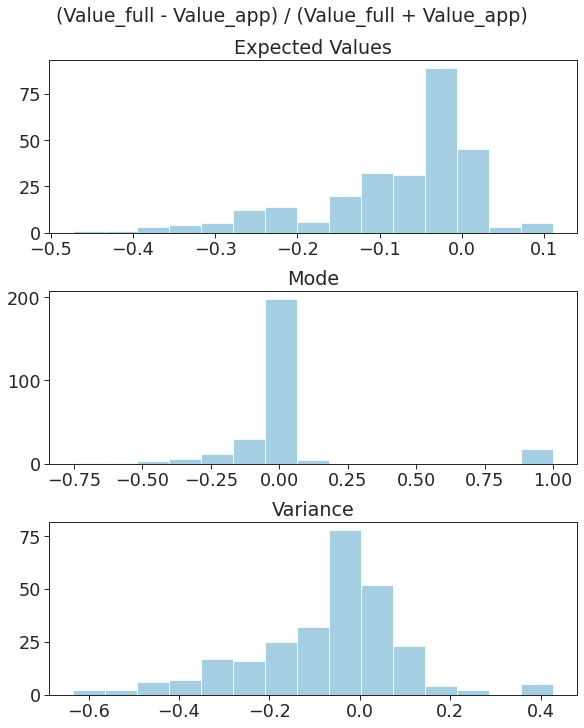

In [21]:
fig, ax= plt.subplots(3,1, figsize=(8,10), constrained_layout=True )
fig.suptitle("(Value_full - Value_app) / (Value_full + Value_app)", fontsize=19)

ax[0].hist(evdiffs, bins=15)
ax[0].set_title("Expected Values")
ax[1].hist(moddiffs, bins=15)
ax[1].set_title("Mode")
ax[2].hist(vardiffs, bins=15)
ax[2].set_title("Variance")
plt.show()

In [22]:
print("Mean EVdiffs: {:.3f}".format(np.mean(evdiffs)))

Mean EVdiffs: -0.078


In [52]:
len(stats_)

271

In [51]:
np.sum(moddiffs==0)

193

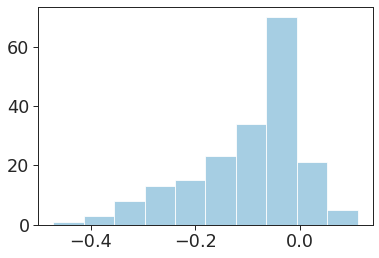

Mean: -0.096


In [23]:
plt.hist(evdiffs[moddiffs==0])
plt.show()
print("Mean: {:.3f}".format(np.mean(evdiffs[moddiffs==0])))

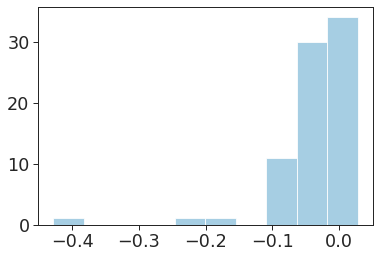

Mean: -0.034


In [24]:
plt.hist(evdiffs[moddiffs != 0])
plt.show()
print("Mean: {:.3f}".format(np.mean(evdiffs[moddiffs!=0])))

In [29]:
# ### Compute observed and expected upper limits
def run2 ( nobs, nExp, nExpErr, nsig ):
    """ run the procedure, with:
    :param nobs: number of observed
    :param nExp: number expected
    :param nExpErr: error on number expected
    """
    print ( "Starting run with nobs", nobs, "nExp", nExp )
    data = Data ( nobs, nExp, nExpErr**2, nsignal = nsig )
    computer = UpperLimitComputer ( 10000 )
    marginalize = False #True
    ULobs = computer.ulSigma ( data, marginalize=marginalize )

    ULexp = computer.ulSigma ( data, expected=True, marginalize=marginalize )

    print(r'Nobs = %1.2f, Nbg = %1.2f +- %1.2f, Nsig < %1.2f, Nsig (expected) < %1.2f'
         %(nobs,nExp,nExpErr,ULobs,ULexp))

    sigma = ULexp/1.96
    mu0 = 0

    def erfroot ( x ):
        return 0.95- (special.erf((ULobs-x)/(np.sqrt(2)*sigma)) +  special.erf(x/(np.sqrt(2)*sigma)))/(1+special.erf(x/(np.sqrt(2)*sigma)) )
    xa,xb=1,1
    if nobs > nExp:
        ua,ub = 0.,2*(3*nExpErr)
        while xa*xb > .0:
            xa,xb= erfroot ( ua ), erfroot ( ub )
            ub = 2*ub
        mu0 = optimize.brentq(lambda x: erfroot(x), ua,ub )
    elif (nobs < nExp):
        ua,ub = -2*(3*nExpErr),2*(3*nExpErr)
        while xa*xb > .0:
            xa,xb= erfroot ( ua ), erfroot ( ub )
            ua = 1.1*ua
            ub = 2*ub
        mu0 = optimize.brentq(lambda x: erfroot(x), ua,ub )
    
    print ( "mu0 = ", mu0 )
    print("Erfroot[mu0]= {}".format(erfroot(mu0)))
    # mu0 = nobs - nExp
    # print ( "mu0", mu0, "nobs", nobs, "nExp", nExp )

    def llhdFromLimits(mu,mu0,sigma):
        return stats.norm.pdf(x=mu,loc=mu0,scale=sigma)

    normLim = 1 - stats.norm.cdf(0,loc=mu0,scale=sigma)
    print(normLim)
    nsteps = 100 # 100

    mulim = abs(nobs-nExp+4*nExpErr)
    norm = p((nobs-nExp)+10*nExpErr,nsig,nExp,nExpErr,nobs)
    while True:
        Lmax1 = likelihood ( mulim, nsig,nExp,nExpErr,nobs)/norm
        Lmax2 = llhdFromLimits ( mulim, mu0, sigma )/normLim
        if max(Lmax1,Lmax2)<.01:
            break
        mulim = 1.2 * mulim
    muvals = np.linspace(0, mulim, nsteps )

    llhds = np.array([[mu,likelihood(mu,nsig,nExp,nExpErr,nobs)/norm] for mu in muvals])
    llhdsApp = np.array([[mu,llhdFromLimits(mu,mu0,sigma)/normLim] for mu in muvals])
    print ( "llhds", llhds[::20] )
    print ( "llhdsApp", llhdsApp[::20] )

    mumax = llhds[np.argmax(llhds[:,1])][0]
    mumaxApp = llhdsApp[np.argmax(llhdsApp[:,1])][0]

    f = plt.figure(figsize=(8,4))
    plt.plot(llhds[:,0],llhds[:,1],label='Full',linewidth=3,color="black")
    plt.plot(llhdsApp[:,0],llhdsApp[:,1],label='From Limits',linestyle='--',linewidth=3)
    plt.legend()
    plt.xlabel(r'$\mu$')
    plt.ylabel(r'$L$')
    plt.text(0,llhdsApp[:,1].min(),'$\mu_{max} = %1.2f$\n$\mu_{max}^{app} = %1.2f$' %(mumax,mumaxApp),fontsize=14)
    plt.title(r'$N_{obs} = %1.2f, N_{bg} = %1.2f \pm %1.2f, \sigma_{UL}^{obs} = %1.2f, \sigma_{UL}^{exp} = %1.2f, \Delta = %1.2f$'
              %(nobs,nExp,nExpErr,ULobs,ULexp,abs(ULobs-ULexp)/(ULobs+ULexp)),fontsize=14)
    plt.savefig("llhd.png")
    #plt.show()

In [26]:
def compareLikelihoods2( nobs, nExp, nExpErr, nsig, plot, print_ ):
    data = Data ( nobs, nExp, nExpErr**2, nsignal = nsig )
    computer = UpperLimitComputer ( 10000 )
    marginalize = False #True
    ULobs = computer.ulSigma ( data, marginalize=marginalize )
    ULexp = computer.ulSigma ( data, expected=True, marginalize=marginalize )

    sigma = ULexp/1.96
    def erfroot ( x ):
        return 0.95- (special.erf((ULobs-x)/(np.sqrt(2)*sigma)) +  special.erf(x/(np.sqrt(2)*sigma)))/(1+special.erf(x/(np.sqrt(2)*sigma)) )
    
    mu0 = 0
    xa,xb=1,1
    if nobs > nExp:
        ua,ub = 0.,2*(3*nExpErr)
        while xa*xb > .0:
            xa,xb= erfroot ( ua ), erfroot ( ub )
            ub = 2*ub
        mu0 = optimize.brentq(lambda x: erfroot(x), ua,ub )
    elif (nobs < nExp):
        ua,ub = -2*(3*nExpErr),2*(3*nExpErr)
        while xa*xb > .0:
            xa,xb= erfroot ( ua ), erfroot ( ub )
            ua = 1.1*ua
            ub = 2*ub
        mu0 = optimize.brentq(lambda x: erfroot(x), ua,ub )
        
    def llhdFromLimits(mu,mu0,sigma):
        return stats.norm.pdf(x=mu,loc=mu0,scale=sigma)

    normLim = 1 - stats.norm.cdf(0,loc=mu0,scale=sigma)

    nsteps = 100 # 100
    
    mulim = abs(nobs-nExp+4*nExpErr)
    norm = p((nobs-nExp)+10*nExpErr,nsig,nExp,nExpErr,nobs)
    while True:
        Lmax1 = likelihood ( mulim, nsig,nExp,nExpErr,nobs)/norm
        Lmax2 = llhdFromLimits ( mulim, mu0, sigma )/normLim
        if max(Lmax1,Lmax2)<.01:
            break
        mulim = 1.2 * mulim
    norm = p(mulim,nsig,nExp,nExpErr,nobs)
    
    
    ev_ex = evLlhd(mulim, nobs, nExp, nExpErr, nsig )
    var_ex =  varLlhd(mulim, ev_ex, nobs, nExp, nExpErr, nsig )
    mod_ex = modLlhd(mu0, nobs, nExp, nExpErr, nsig)
    
    ev_app = evLlhdApp(mu0, sigma)
    var_app = varLlhdApp(mu0, sigma)
    if (mu0>0):
        mod_app = mu0
    else:
        mod_app = 0.0
        
    
    if print_:   
        print("\tE[mu] \t\tVar[mu] \tMode[mu]\
            \nFull \t{:7.4f} \t{:7.4f} \t{:7.4f}\
            \nApp \t{:7.4f} \t{:7.4f} \t{:7.4f}".format(ev_ex, var_ex, mod_ex, ev_app, var_app, mod_app))

    if plot:
        muvals = np.linspace(0, mulim, nsteps )
        llhds = np.array([[mu,likelihood(mu,nsig,nExp,nExpErr,nobs)/norm] for mu in muvals])
        llhdsApp = np.array([[mu,llhdFromLimits(mu,mu0,sigma)/normLim] for mu in muvals])
      
        mumax = llhds[np.argmax(llhds[:,1])][0]
        mumaxApp = llhdsApp[np.argmax(llhdsApp[:,1])][0]

        f = plt.figure(figsize=(8,4))
        plt.plot(llhds[:,0],llhds[:,1],label='Full',linewidth=3,color="black")
        plt.plot(llhdsApp[:,0],llhdsApp[:,1],label='From Limits',linestyle='--',linewidth=3)
        plt.legend()
        plt.xlabel(r'$\mu$')
        plt.ylabel(r'$L$')
        plt.text(0,llhdsApp[:,1].min(),'$\mu_{max} = %1.2f$\n$\mu_{max}^{app} = %1.2f$' %(mumax,mumaxApp),fontsize=14)
        plt.title(r'$N_{obs} = %1.2f, N_{bg} = %1.2f \pm %1.2f, \sigma_{UL}^{obs} = %1.2f, \sigma_{UL}^{exp} = %1.2f, \Delta = %1.2f$'
                  %(nobs,nExp,nExpErr,ULobs,ULexp,abs(ULobs-ULexp)/(ULobs+ULexp)),fontsize=14)
        plt.savefig("llhd.png")
        #plt.show()
        
    return({"ev_ex":ev_ex, "var_ex":var_ex, "mod_ex":mod_ex, "ev_app":ev_app, "var_app":var_app, "mod_app":mod_app} )
 

In [27]:
j = 110
run(int(stats_[j]["obsN"]), stats_[j]["expectedBG"], stats_[j]["bgError"], 1)

NameError: name 'run' is not defined

In [28]:
run2(int(stats_[j]["obsN"]), stats_[j]["expectedBG"], stats_[j]["bgError"], 1)

NameError: name 'run2' is not defined

In [29]:
LlhdMeta2 = []
plot, print_ = False, False
counter = 0
for i in tqdm(stats_):
    counter += 1
    LlhdMeta2.append(compareLikelihoods2(int(i["obsN"]), i["expectedBG"], i["bgError"], 1, plot, print_))

  0%|          | 0/271 [00:00<?, ?it/s]

In [30]:
evdiffs2 = np.array([reldiff(i["ev_ex"], i["ev_app"]) for i in LlhdMeta2])
vardiffs2 = np.array([reldiff(i["ev_ex"], i["ev_app"]) for i in LlhdMeta2])
moddiffs2 = np.array([reldiff(i["mod_ex"], i["mod_app"]) for i in LlhdMeta2])

Text(0.5, 1.0, 'Variances Method 2')

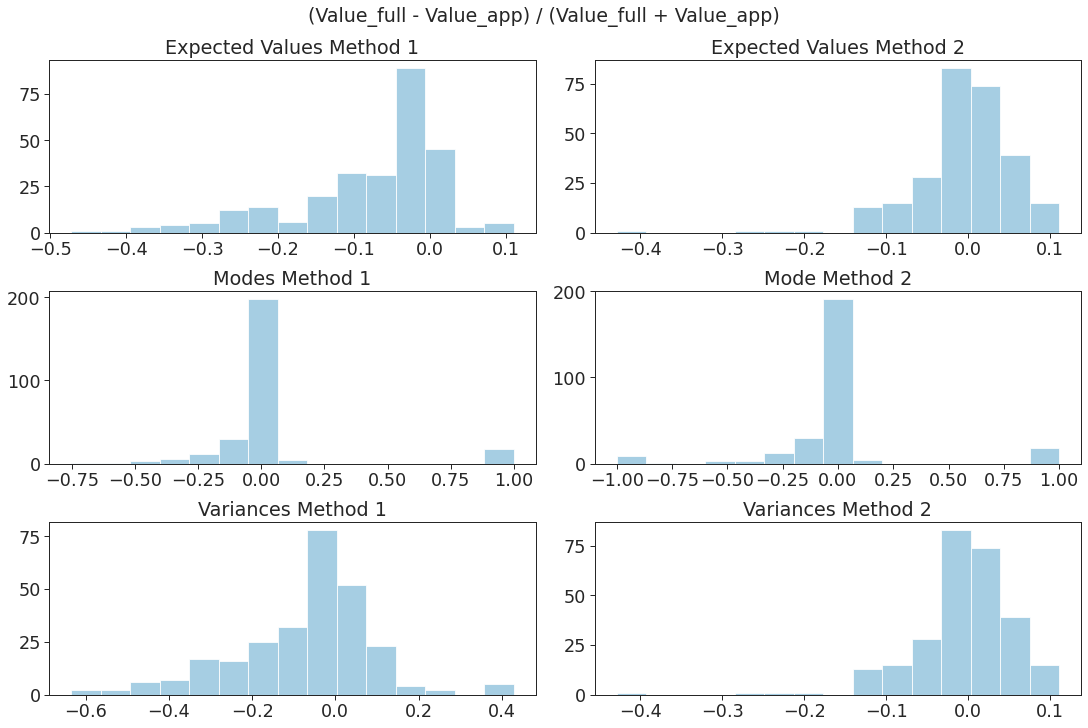

In [31]:
fig, ax= plt.subplots(3,2, figsize=(15,10), constrained_layout=True )
fig.suptitle("(Value_full - Value_app) / (Value_full + Value_app)", fontsize=19)

ax[0,0].hist(evdiffs, bins=15)
ax[0,0].set_title("Expected Values Method 1")
ax[0,1].hist(evdiffs2, bins=15)
ax[0,1].set_title("Expected Values Method 2")
ax[1,0].hist(moddiffs, bins=15)
ax[1,0].set_title("Modes Method 1")
ax[1,1].hist(moddiffs2, bins=15)
ax[1,1].set_title("Mode Method 2")
ax[2,0].hist(vardiffs, bins=15)
ax[2,0].set_title("Variances Method 1")
ax[2,1].hist(vardiffs2, bins=15)
ax[2,1].set_title("Variances Method 2")

In [32]:
print("Mean EVdiffs Method 1: {:.3f}".format(np.mean(evdiffs)))

Mean EVdiffs Method 1: -0.078


In [33]:
print("Mean EVdiffs Method 2: {:.3f}".format(np.mean(evdiffs2)))

Mean EVdiffs Method 2: -0.007


In [46]:
stats_[249]

{'obsN': 2,
 'expectedBG': 0.5,
 'bgError': 2.6,
 'upperLimit': 4.49E-01 [fb],
 'expectedUpperLimit': 2.96E-01 [fb]}

In [25]:
j = 2
run(int(stats_[j]["obsN"]), stats_[j]["expectedBG"], stats_[j]["bgError"], 1)

NameError: name 'run' is not defined

In [26]:
run2(int(stats_[j]["obsN"]), stats_[j]["expectedBG"], stats_[j]["bgError"], 1)

NameError: name 'run2' is not defined

In [47]:
evdiffs[249]

-0.42887438128461225

{'obsN': 9,
 'expectedBG': 11.5,
 'bgError': 3.6,
 'upperLimit': 4.60E-01 [fb],
 'expectedUpperLimit': 5.42E-01 [fb]}

Starting run with nobs 160 nExp 100
Nobs = 160.00, Nbg = 100.00 +- 20.00, Nsig < 102.30, Nsig (expected) < 44.11
mu0 =  65.26771441246295
Erfroot[mu0]= 1.1102230246251565e-16
0.9981362216949663
llhds [[0.00000000e+00 5.91021178e-04]
 [2.82828283e+01 6.55532298e-03]
 [5.65656566e+01 1.66700865e-02]
 [8.48484848e+01 1.01100168e-02]
 [1.13131313e+02 1.52513309e-03]]
llhdsApp [[0.00000000e+00 2.64747555e-04]
 [2.82828283e+01 4.60173677e-03]
 [5.65656566e+01 1.64816144e-02]
 [8.48484848e+01 1.21637051e-02]
 [1.13131313e+02 1.84978043e-03]]


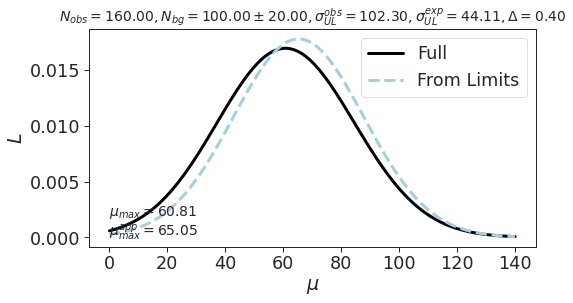

In [45]:
if __name__ == "__main__":
    stats_ = getSRs()
    #print ( stats 

    #sys.exit()

    nobs = 160
    nExp = 100
    nExpErr = 20.0
    nsig = 1 #Keep it at one in order to compare the likelihoods
    # was ist nsig überhaupts genau?

    run ( nobs, nExp, nExpErr, nsig )

In [35]:
def compareLikelihoods_exp( nobs, nExp, nExpErr, nsig, plot, print_ ):
    data = Data ( nobs, nExp, nExpErr**2, nsignal = nsig )
    computer = UpperLimitComputer ( 10000 )
    marginalize = False #True
    ULobs = computer.ulSigma ( data, marginalize=marginalize )
    ULexp = computer.ulSigma ( data, expected=True, marginalize=marginalize )

    sigma = ULexp/1.96
    def erfroot ( x ):
        return 0.95- (special.erf((ULobs-x)/(np.sqrt(2)*sigma)) +  special.erf(x/(np.sqrt(2)*sigma)))/(1+special.erf(x/(np.sqrt(2)*sigma)) )
    
    mu0 = 0
    xa,xb=1,1
    if nobs > nExp:
        ua,ub = 0.,2*(3*nExpErr)
        while xa*xb > .0:
            xa,xb= erfroot ( ua ), erfroot ( ub )
            ub = 2*ub
        mu0 = optimize.brentq(lambda x: erfroot(x), ua,ub )
    else:
        mu0 = -1
        sigma = -np.log(0.05)/ULobs
        
    def llhdFromLimits(mu,mu0,sigma):
        if mu0 == -1:
            return stats.expon.pdf(x=mu, scale=1/sigma)
        else:
            return stats.norm.pdf(x=mu,loc=mu0,scale=sigma)

    if mu0 == -1:
        normLim = 1 
    else:
        normLim = 1 - stats.norm.cdf(0,loc=mu0,scale=sigma)

    nsteps = 100 # 100
    
    mulim = abs(nobs-nExp+4*nExpErr)
    norm = p((nobs-nExp)+10*nExpErr,nsig,nExp,nExpErr,nobs)
    while True:
        Lmax1 = likelihood ( mulim, nsig,nExp,nExpErr,nobs)/norm
        Lmax2 = llhdFromLimits ( mulim, mu0, sigma )/normLim
        if max(Lmax1,Lmax2)<.01:
            break
        mulim = 1.2 * mulim
    norm = p(mulim,nsig,nExp,nExpErr,nobs)
    
    
    ev_ex = evLlhd(mulim, nobs, nExp, nExpErr, nsig )
    var_ex =  varLlhd(mulim, ev_ex, nobs, nExp, nExpErr, nsig )
    mod_ex = modLlhd(mu0, nobs, nExp, nExpErr, nsig)
    
    ev_app = evLlhdApp(mu0, sigma)
    var_app = varLlhdApp(mu0, sigma)
    if (mu0>0):
        mod_app = mu0
    else:
        mod_app = 0.0
        
    
    if print_:   
        print("\tE[mu] \t\tVar[mu] \tMode[mu]\
            \nFull \t{:7.4f} \t{:7.4f} \t{:7.4f}\
            \nApp \t{:7.4f} \t{:7.4f} \t{:7.4f}".format(ev_ex, var_ex, mod_ex, ev_app, var_app, mod_app))

    if plot:
        muvals = np.linspace(0, mulim, nsteps )
        llhds = np.array([[mu,likelihood(mu,nsig,nExp,nExpErr,nobs)/norm] for mu in muvals])
        llhdsApp = np.array([[mu,llhdFromLimits(mu,mu0,sigma)/normLim] for mu in muvals])
      
        mumax = llhds[np.argmax(llhds[:,1])][0]
        mumaxApp = llhdsApp[np.argmax(llhdsApp[:,1])][0]

        f = plt.figure(figsize=(8,4))
        plt.plot(llhds[:,0],llhds[:,1],label='Full',linewidth=3,color="black")
        plt.plot(llhdsApp[:,0],llhdsApp[:,1],label='From Limits',linestyle='--',linewidth=3)
        plt.legend()
        plt.xlabel(r'$\mu$')
        plt.ylabel(r'$L$')
        plt.text(0,llhdsApp[:,1].min(),'$\mu_{max} = %1.2f$\n$\mu_{max}^{app} = %1.2f$' %(mumax,mumaxApp),fontsize=14)
        plt.title(r'$N_{obs} = %1.2f, N_{bg} = %1.2f \pm %1.2f, \sigma_{UL}^{obs} = %1.2f, \sigma_{UL}^{exp} = %1.2f, \Delta = %1.2f$'
                  %(nobs,nExp,nExpErr,ULobs,ULexp,abs(ULobs-ULexp)/(ULobs+ULexp)),fontsize=14)
        plt.savefig("llhd.png")
        #plt.show()
        
    return({"ev_ex":ev_ex, "var_ex":var_ex, "mod_ex":mod_ex, "ev_app":ev_app, "var_app":var_app, "mod_app":mod_app} )
 

	E[mu] 		Var[mu] 	Mode[mu]            
Full 	 1.4801 	 1.6087 	 0.0000            
App 	 0.4425 	 0.1444 	 0.0000


{'ev_ex': 1.4801285405198419,
 'var_ex': 1.6087179895182517,
 'mod_ex': 0.0,
 'ev_app': 0.4424974452016628,
 'var_app': 0.14442513897015677,
 'mod_app': 0.0}

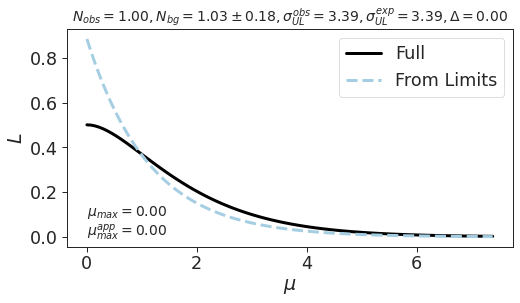

In [37]:
j=2
compareLikelihoods_exp(stats_[j]["obsN"], stats_[j]["expectedBG"], stats_[j]["bgError"], 1, True, True)

In [38]:
LlhdMetaExp = []
plot, print_ = False, False
counter = 0
for i in tqdm(stats_):
    counter += 1
    LlhdMetaExp.append(compareLikelihoods_exp(int(i["obsN"]), i["expectedBG"], i["bgError"], 1, plot, print_))

  0%|          | 0/271 [00:00<?, ?it/s]

<ipython-input-14-92cce153f9d5>:2: RuntimeWarning: divide by zero encountered in double_scalars
  lam = np.exp(-mu0**2/(2*sigma**2)) / (np.sqrt(2*np.pi)*(1 - stats.norm.cdf(0,loc=mu0,scale=sigma)))
<ipython-input-14-92cce153f9d5>:6: RuntimeWarning: divide by zero encountered in double_scalars
  lam = np.exp(-mu0**2/(2*sigma**2)) / (np.sqrt(2*np.pi)*(1 - stats.norm.cdf(0,loc=mu0,scale=sigma)))
<ipython-input-14-92cce153f9d5>:7: RuntimeWarning: invalid value encountered in double_scalars
  return(sigma**2*(1 - lam*mu0/sigma - lam**2))
<ipython-input-14-92cce153f9d5>:2: RuntimeWarning: divide by zero encountered in double_scalars
  lam = np.exp(-mu0**2/(2*sigma**2)) / (np.sqrt(2*np.pi)*(1 - stats.norm.cdf(0,loc=mu0,scale=sigma)))
<ipython-input-14-92cce153f9d5>:6: RuntimeWarning: divide by zero encountered in double_scalars
  lam = np.exp(-mu0**2/(2*sigma**2)) / (np.sqrt(2*np.pi)*(1 - stats.norm.cdf(0,loc=mu0,scale=sigma)))
<ipython-input-14-92cce153f9d5>:7: RuntimeWarning: invalid value 

KeyboardInterrupt: 

In [30]:
evdiffs2 = np.array([reldiff(i["ev_ex"], i["ev_app"]) for i in LlhdMeta2])
vardiffs2 = np.array([reldiff(i["ev_ex"], i["ev_app"]) for i in LlhdMeta2])
moddiffs2 = np.array([reldiff(i["mod_ex"], i["mod_app"]) for i in LlhdMeta2])